<a href="https://colab.research.google.com/github/beamscource/colab_notebooks/blob/main/ml_models_deployment_apps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Practical challenges for ML model deployment**

- Coordination Between Stakeholders
- Programming Language Discrepancy between overall app and the ML model
- Model/concept Drift
- On-Prem vs. Cloud-Based Deployment
- Clear Ownership
- Model Performance Monitoring
- Release/Version Management
- Privacy and data security

We can break model deployment into four different approaches.

• Deploying a model locally (with Jupyter)

• Saving the model on a production server

• Deploying the model as a REST service (e.g., with Flask)

• Managed services

The general deployment process involves following steps:

  1.   Train the ML model.
  2.   Save and export the ML model.
  3.   Create a Flask app including the UI layer.
  4.   Build a custom Docker image for the app.
  5.   Run the app using a Docker container.


# Web frameworks

## **Flask**

When we want to connect our ML model to an app or a web service, we essentially need to deploy it using a web server. This web server can be hosted locally or in the cloud.

First, we train a ML model and pickle it:

In [ ]:
# Example 1: train a linear regression model
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import joblib

df=pd.read_csv('Linear_regression_dataset. csv',header='infer')

# take all columns as features apart from the column with output labels
X=df.loc[:,df.columns !='output']
y=df['output']

# fit the model
lr = LinearRegression().fit(X, y)
lr.score(X,y)

# save the trained model as pkl file
joblib.dump(lr,'inear_regression_model.pkl')

In [ ]:
# Example 2: train a logistic regression model
import numpy as np
import pandas as pd
df = pd.read_csv('online_sales.csv') # replace it for the dataiku set
#df.shape
#df.head()
#df.converted.value_counts()
#df.info()

# take care of missing values, clean, transform

input_columns = [column for column in df.columns if column != 'converted']
#print (input_columns)
#['age', 'new_user', 'total_pages_visited']
output_column = 'converted'
#print (output_column)
#converted
X = df.loc[:,input_columns].values
y = df.loc[:,output_column]

#print (X.shape, y.shape)
#(316200, 3) (316200,)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=555, stratify=y)
#print(np.sum(y_train))
#7140
#print(np.sum(y_test))
#3060

# model fitting
logreg=LogisticRegression(class_weight='balanced').fit(X_train,y_train)
#logreg.score(X_test, y_test)
#0.93

# model evaluation
predictions=logreg.predict(X_test)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# get a metrics table
print(classification_report(y_test,predictions,target_names=["Non Converted", "Converted"]))

# save the model
import pickle
with open("logreg.pkl","wb") as f:
  pickle.dump(logreg, f)


In [ ]:
# Example 3: train a random forest model on iris data
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import pickle

# load data
iris = load_iris()
X = iris.data
y = iris.target

# split the data
X_train, X_test, y_train, y_test = train_testsplit(X, y, random_state=0, test_size=0.2)

model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)

# predict
predicted = model.predict(X_test)
# print accuracy
print(accuracy_score(predicted, y_test))

# save the model
with open('path/model_rf.pkl', 'wb') as f:
  pickle.dumb(model, f)

Secondly, write a web app to interface with the model:

In [ ]:
# write a Flask app for Example 1
import pandas as pd
import numpy as np
import sklearn
import joblib
from flask import Flask,render_template,request

app=Flask(__name__)

@app.route('/')
def home():
  return render_template('home.html')

@app.route('/predict',methods=['GET','POST'])
def predict():
  if request.method =='POST':
    print(request.form.get('var_1')) 
    print(request.form.get('var_2'))
    print(request.form.get('var_3'))
    print(request.form.get('var_4'))
    print(request.form.get('var_5'))
    try:
      
      # not using request.args.get doesn't allow to pass arguments as URL parameters
      # instead parameters are passed through HTML forms
      # for image and sound data this is the only way to do it

      var_1=float(request.form['var_1']) # using the POST method
      var_2=float(request.form['var_2'])
      var_3=float(request.form['var_3'])
      var_4=float(request.form['var_4'])
      var_5=float(request.form['var_5'])
      
      # combine arguments into an array
      pred_args=[var_1,var_2,var_3,var_4,var_5]
      pred_arr=np.array(pred_args)
      preds=pred_arr.reshape(1,-1)


      # load model
      model=open("linear_regression_model. pkl","rb")
      lr_model=joblib.load(model)
      
      model_prediction=lr_model.predict(preds)
      model_prediction=round(float(model_ prediction),2)
    
    except ValueError:
      return "Please Enter valid values"
    
    # return model's prediction through a HTML template
    return render_template('predict.html',prediction=model_ prediction)
    
if __name__=='__main__':
  app.run(host='0.0.0.0')

# run it at the terminal
python main.py


**Model UI with HTML or Swagger**

With a web framework, we can define custom HTML forms for the GUI. Here is an example of the HTML code for the input requests for Example 1:

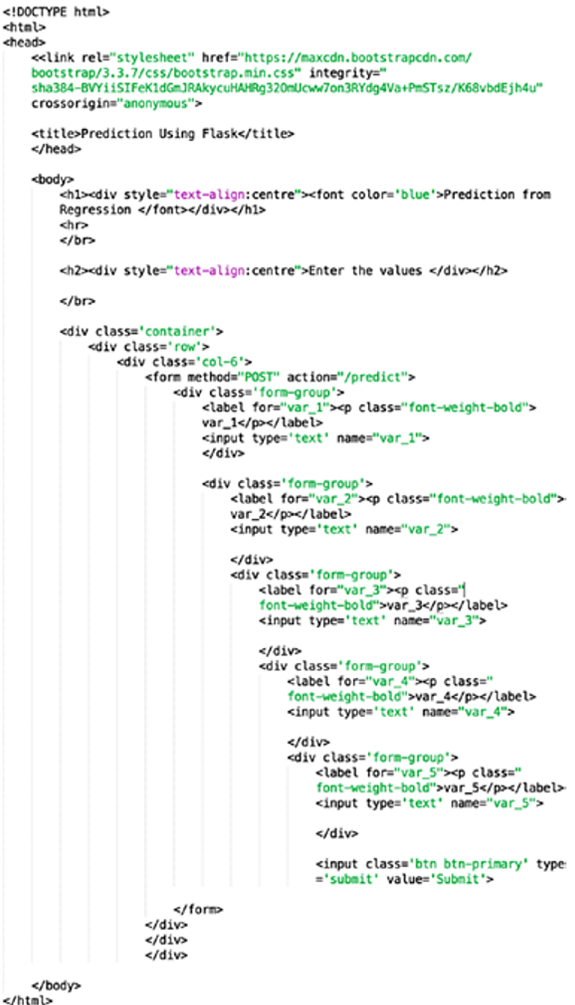

And the model request form:

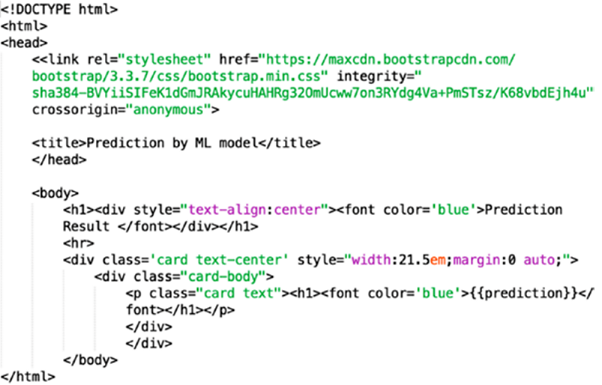

However, to avoid writing HTML templates, we can use Swagger which allows to automatically create a simple UI along some documentation for a Flask app. You'll find the UI at the */apidocs* endpoint of the app. Here is an example for Example 2:

In [ ]:
# create a Flask app including a Swagger UI
from flask import Flask, request
import numpy as np
import pickle
import pandas as pd
from flasgger import Swagger

app=Flask(__name__)
swagger = Swagger(app)
# without the Swagger UI you can still send a file using Postman

# load the model at the beginning
with open("logreg.pkl","rb") as f:
  model=pickle.load(f)

@app.route('/predict', methods=["GET"])
# for Swagger you need to provide a docstring
def predict_class():
    """Predict if Customer would buy the product or not.
    ---
    parameters:
      - name: age
        in: query
    type: number
        required: true
      - name: new_user
        in: query
        type: number
        required: true
      - name: total_pages_visited
        in: query
        type: number
        required: true
    responses:
        500:
            description: Prediction
    """
    
  age=int(request.args.get("age"))
  new_user=int(request.args.get("new_user"))
  total_pages_visited=int(request.args.get("total_pages_visited"))

  # input as an array of arrays
  prediction=model.predict(np.array([[age,new_user,total_pages_visited]]))

  print(prediction[0])
  return "Model prediction is"+str(prediction)

@app.route('/predict_file',methods=["POST"])
def prediction_test_file():
    """Prediction on multiple test inputs with a file.
    ---
    parameters:
      - name: file
        in: formData
    type: file
    required: true
     responses:
          500:
             description: Test file Prediction
    """
    
    df_test=pd.read_csv(request.files.get("file"), header=None)
    prediction=model.predict(df_test)
    
    # return predictions as a list
    return str(list(prediction))

if __name__=='__main__':
  app.run(debug=True,host='0.0.0.0') # localhost

**Packaging the web app into a Docker image**

Once we have a model and the corresponding Flask app, we can package it into a Docker image and run it as a container.

In [ ]:
# Dockerfile
FROM continuumio/anaconda3:4.4.0 # Python 3 is used
# copy all files required to build the Flask app including requirements.txt
COPY .flask_app /usr/ML/app # /usr/local/flask_app
# expose port 5000 to run the app
EXPOSE 5000
WORKDIR /usr/ML/app # /usr/local/flask_app
RUN pip install -r requirements.txt
# run the app
CMD python flask_api.py

# requirements.txt
flask
flasgger
# other ds related packages are already inside of the anaconda image

# directory structure
tree
.
├── Dockerfile
├── flask_app
    │── flas_app.py
    │── model.pkl
    │── requirements.txt

# start Docker engine

# build the docker image
docker build -t ml_flask_app .

# run the image containing the app
docker run -p 5000:5000 ml_flask_app

## **Fast API**

https://towardsdatascience.com/how-to-deploy-a-machine-learning-model-with-fastapi-docker-and-github-actions-13374cbd638a

https://towardsdatascience.com/how-you-can-quickly-deploy-your-ml-models-with-fastapi-9428085a87bf





## **BentoML**

Is a model serving framework aiming at replacing Flask and FastAPI.

- https://modelserving.com/blog/breaking-up-with-flask-amp-fastapi-why-ml-model-serving-requires-a-specialized-framework
- https://docs.bentoml.org/en/latest/

# Dashboard apps

Dashboard apps are an alternative to Flask/FastAPI for deploying machine learning models as a web service. The biggest advantage of using such apps is that the front-end part is much easier to set-up.

## **Streamlit**

In [ ]:
# example with streamlit
import pandas as pd
import numpy as np
import joblib
import streamlit

model=open("linear_regression_model.pkl","rb")
lr_model=joblib.load(model)

def lr_prediction(var_1,var_2,var_3,var_4,var_5):
  pred_arr=np.array([var_1,var_2,var_3,var_4,var_5])
  preds=pred_arr.reshape(1,-1)
  preds=preds.astype(int)
  model_prediction=lr_model.predict(preds)
  
  return model_prediction

# function for user input and front-end functionality
def run():
  streamlit.title("Linear Regression Model")
  html_temp="""
            """
            streamlit.markdown(html_temp)
  var_1=streamlit.text_input("Variable 1")
  var_2=streamlit.text_input("Variable 2")
  var_3=streamlit.text_input("Variable 3")
  var_4=streamlit.text_input("Variable 4")
  var_5=streamlit.text_input("Variable 5")
  prediction=""
  
  if streamlit.button("Predict"):
    prediction=lr_prediction(var_1,var_2,var_3,var_4,var_5)
  
  streamlit.success("The prediction by Model : ­{}".
  format(prediction))

if __name__=='__main__':
  run()

# execute at the terminal
streamlit run app.py

## **HuggingFace Gradio**



- https://tmabraham.github.io/blog/gradio_hf_spaces_tutorial
- https://www.youtube.com/watch?v=eE7CamOE-PA

## **Mercury and Voila**

You can easily convert Jupyter notebooks into a web app with
- https://github.com/mljar/mercury
- https://github.com/voila-dashboards/voila

Additional interactive vizualisation tools:
- https://ipywidgets.readthedocs.io/en/stable/
- https://towardsdatascience.com/a-quick-way-to-build-applications-in-python-51d5ef477d88

## **Other**

- https://plotly.com/
- https://www.datarevenue.com/en-blog/data-dashboarding-streamlit-vs-dash-vs-shiny-vs-voila